# 3. FOR ALL INTERVALS IN TRAINING SET: calculate correction

In [1]:
import pickle
import pandas as pd
import numpy as np
import shutil
import src.sf_funcs as sf
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set_theme(style="whitegrid", font_scale=1.5)

## Train-test split

In [2]:
# # Randomly select 20% of the pickle files in data/processed/psp, and move them into a subfolder called 'test'
# # The remaining 80% will be moved into a subfolder called 'train'

# # Get all the pickle files in data/psp/processed
# processed_files = sorted(glob.glob("data/processed/psp/psp_*.pkl"))

# train_frac = 0.6

# # Randomly shuffle the list of pickle files
# np.random.seed(123) # For reproducibility
# np.random.shuffle(processed_files)

# # Split the list of pickle files into a training set and a test set
# n_files = len(processed_files)
# n_train = int(train_frac * n_files)

# train_files = processed_files[:n_train]
# test_files = processed_files[n_train:]

# # Create the 'train' and 'test' subfolders if they don't already exist
# os.makedirs("data/processed/psp/train", exist_ok=True)

# # Move the training files into the 'train' subfolder
# for file in train_files:
#     shutil.move(file, file.replace("processed/psp", "processed/psp/train"))

# # Create the 'test' subfolder if it doesn't already exist
# os.makedirs("data/processed/psp/test", exist_ok=True)

# # Move the test files into the 'test' subfolder
# for file in test_files:
#     shutil.move(file, file.replace("processed/psp", "processed/psp/test"))

# # Check the number of files in each subfolder
# train_files = sorted(glob.glob("data/processed/psp/train/psp_*.pkl"))
# test_files = sorted(glob.glob("data/processed/psp/test/psp_*.pkl"))

# print(f"Number of files in PSP 'train' subfolder: {len(train_files)}")
# print(f"Number of files in PSP 'test' subfolder: {len(test_files)}")

Number of files in PSP 'train' subfolder: 3
Number of files in PSP 'test' subfolder: 2


In [10]:
spacecraft = "psp"
input_file_list = [sorted(glob.glob("data/processed/psp/train/psp_*.pkl"))][0]

files_metadata, ints_metadata, ints, ints_gapped_metadata, ints_gapped, sfs, sfs_gapped = sf.load_and_concatenate_dataframes(
    input_file_list)


## Calculate lag-scale errors (sf_2_pe)
Join original and copies dataframes and do column operation

In [11]:
ints_gapped_metadata = pd.merge(ints_metadata, ints_gapped_metadata, how="inner", on=["file_index", "int_index"], suffixes=("_orig", ""))

In [12]:
sfs_gapped = pd.merge(sfs, sfs_gapped, how="inner", on=["file_index", "int_index", "lag"], suffixes=("_orig", ""))
sfs_gapped["sf_2_pe"] = (sfs_gapped["sf_2"] - sfs_gapped["sf_2_orig"]) / sfs_gapped["sf_2_orig"] * 100

## Compute and export heatmaps

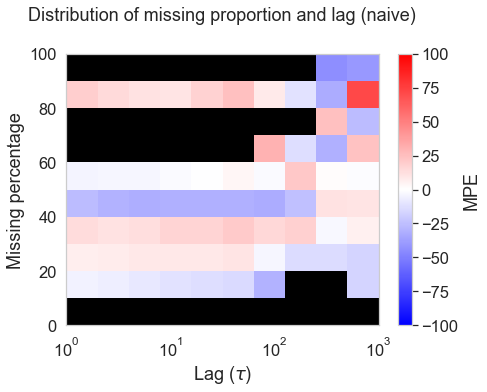

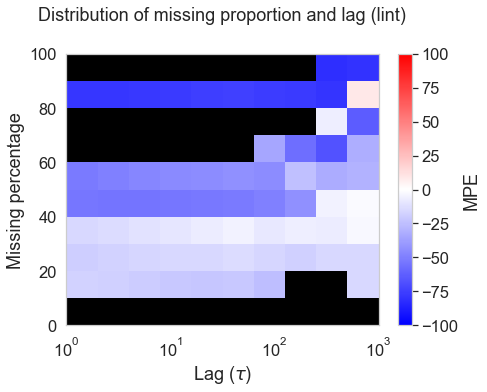

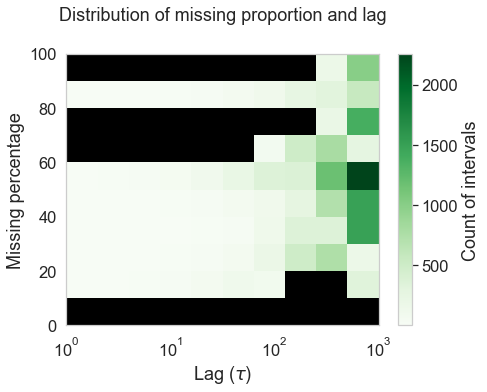

In [13]:
n_bins = 10

for gap_handling in ["naive", "lint"]:
    heatmap_bin_vals_2d, heatmap_bin_counts_2d, heatmap_bin_edges_2d, lookup_table_2d = sf.create_heatmap_lookup(
        sfs_gapped[sfs_gapped["gap_handling"]==gap_handling], "missing_percent", n_bins, log=True
    )

    # Mean percentage error per bin
    fig, ax = plt.subplots(figsize=(7, 5))
    plt.pcolormesh(
        heatmap_bin_edges_2d[0],
        heatmap_bin_edges_2d[1],
        heatmap_bin_vals_2d.T,
        cmap="bwr",
    )
    plt.colorbar(label="MPE")
    plt.clim(-100, 100)
    plt.xlabel("Lag ($\\tau$)")
    plt.ylabel("Missing percentage")
    plt.title(f"Distribution of missing proportion and lag ({gap_handling})", y=1.1)
    ax.set_facecolor("black")
    ax.set_xscale("log")
    ax.grid(False)

    plt.savefig(f"plots/temp/train_{spacecraft}_heatmap_{n_bins}bins_2d_{gap_handling}.jpg", bbox_inches='tight')

# Count of pairs per bin (same for both)
fig, ax = plt.subplots(figsize=(7, 5))
plt.pcolormesh(
    heatmap_bin_edges_2d[0],
    heatmap_bin_edges_2d[1],
    heatmap_bin_counts_2d.T,
    cmap="Greens",
)
# Remove gridlines
plt.colorbar(label="Count of intervals")
plt.xlabel("Lag ($\\tau$)")
plt.ylabel("Missing percentage")
plt.title(f"Distribution of missing proportion and lag", y=1.1)
ax.set_facecolor("black")
ax.set_xscale("log")
ax.grid(False)
plt.savefig(f"plots/temp/train_{spacecraft}_heatmap_{n_bins}bins_2d_counts.jpg", bbox_inches='tight')

Potential future sample size analysis

In [14]:
# Get proportion of nans in the flattened array
#print(np.isnan(heatmap_bin_counts_2d.flatten()).sum() / len(heatmap_bin_counts_2d.flatten())*100, "% of bins in the grid have no corresponding data")

# Summarise this array in terms of proportion of missing values, minimum value, and median value
#print(np.nanmedian(heatmap_bin_counts_2d), "is the median count of each bin")

# For each heatmap, print these stats.
# Also, for the correction part, note when there is no corresponding bin.

In [15]:
# Because the LINT version was calculated most recently, this is what we have here
lookup_table_2d.head()

,lag,missing_percent,n,mpe,mpe_sd,pe_min,pe_max,scaling,scaling_lower,scaling_upper
0,1.487531,15.0,4,-17.819572,3.823724,-24.407379,-15.020078,1.216835,1.176749,1.322880
1,1.487531,25.0,2,-19.077224,3.782635,-22.859859,-15.294589,1.235746,1.180562,1.296342
2,1.487531,35.0,1,-15.052012,0.000000,-15.052012,-15.052012,1.177191,1.177191,1.177191
3,1.487531,45.0,2,-53.611373,8.924488,-62.535861,-44.686886,2.155701,1.807890,2.669219
4,1.487531,55.0,7,-52.052514,17.782916,-80.063845,-29.816937,2.085615,1.424845,5.016012


In [16]:
gap_handling = "lint"

heatmap_bin_vals_3d, heatmap_bin_edges_3d, lookup_table_3d = (
    sf.create_heatmap_lookup_3D(
        sfs_gapped[sfs_gapped["gap_handling"]==gap_handling], "missing_percent", n_bins, True
    )
)

# Plotting 3D heatmaps

fig, ax = plt.subplots(1, n_bins, figsize=(n_bins * 3, 3.5), tight_layout=True)
# Remove spacing between subplots
plt.subplots_adjust(wspace=0.2)
for i in range(n_bins):
    c = ax[i].pcolormesh(
        heatmap_bin_edges_3d[0],
        heatmap_bin_edges_3d[1],
        heatmap_bin_vals_3d[:, :, i],
        cmap="bwr",
    )
    # plt.colorbar(label="MPE")
    c.set_clim(-100, 100)
    plt.xlabel("Lag ($\\tau$)")
    plt.ylabel("Missing proportion")
    plt.title("Distribution of missing proportion and lag")
    ax[i].set_facecolor("black")
    ax[i].semilogx()
    ax[i].set_title(
        f"Power bin {i+1}/{n_bins}".format(np.round(heatmap_bin_edges_3d[2][i], 2))
    )
    ax[i].set_xlabel("Lag ($\\tau$)")
    # Remove y-axis labels for all but the first plot
    if i > 0:
        ax[i].set_yticklabels([])
        ax[i].set_ylabel("")
plt.savefig(f"plots/temp/train_{spacecraft}_heatmap_{n_bins}bins_3d_{gap_handling}_power.jpg", bbox_inches='tight')
plt.close()

fig, ax = plt.subplots(1, n_bins, figsize=(n_bins * 3, 3.5), tight_layout=True)
# Remove spacing between subplots
plt.subplots_adjust(wspace=0.2)
for i in range(n_bins):
    c = ax[i].pcolormesh(
        heatmap_bin_edges_3d[1],
        heatmap_bin_edges_3d[2],
        heatmap_bin_vals_3d[i, :, :],
        cmap="bwr",
    )
    # plt.colorbar(label="MPE")
    c.set_clim(-100, 100)
    ax[i].set_xlabel("Missing prop")
    ax[i].set_ylabel("Power")
    plt.title("Distribution of missing proportion and lag")
    ax[i].set_facecolor("black")
    ax[i].semilogy()
    ax[i].set_title(
        f"Lag bin {i+1}/{n_bins}".format(np.round(heatmap_bin_edges_3d[2][i], 2))
    )
    ax[i].set_xlabel("Missing prop")
    # Remove y-axis labels for all but the first plot
    if i > 0:
        ax[i].set_yticklabels([])
        ax[i].set_ylabel("")
plt.savefig(f"plots/temp/train_{spacecraft}_heatmap_{n_bins}bins_3d_{gap_handling}_lag.jpg", bbox_inches='tight')
plt.close()

fig, ax = plt.subplots(1, n_bins, figsize=(n_bins * 3, 3.5), tight_layout=True)
# Remove spacing between subplots
plt.subplots_adjust(wspace=0.2)
for i in range(n_bins):
    c = ax[i].pcolormesh(
        heatmap_bin_edges_3d[0],
        heatmap_bin_edges_3d[2],
        heatmap_bin_vals_3d[:, i, :],
        cmap="bwr",
    )
    # plt.colorbar(label="MPE")
    c.set_clim(-100, 100)
    plt.title("Distribution of missing proportion and lag")
    ax[i].set_facecolor("black")
    ax[i].semilogx()
    ax[i].semilogy()
    ax[i].set_title(
        f"Missing prop bin {i+1}/{n_bins}".format(
            np.round(heatmap_bin_edges_3d[2][i], 2)
        )
    )
    ax[i].set_xlabel("Lag ($\\tau$)")
    ax[i].set_ylabel("Power")
    # Remove y-axis labels for all but the first plot
    if i > 0:
        ax[i].set_yticklabels([])
        ax[i].set_ylabel("")
plt.savefig(f"plots/temp/train_{spacecraft}_heatmap_{n_bins}bins_3d_{gap_handling}_missing.jpg", bbox_inches='tight')
plt.close()

In [17]:
lookup_table_3d.head()

,lag,missing_percent,sf_2,mpe,mpe_sd,pe_min,pe_max,scaling,scaling_lower,scaling_upper
0,1.487531,15.0,0.014976,-24.407379,0.000000,-24.407379,-24.407379,1.322880,1.322880,1.322880
1,1.487531,15.0,0.029882,-15.623636,0.453822,-16.114411,-15.020078,1.185166,1.176749,1.192100
2,1.487531,25.0,0.029882,-19.077224,3.782635,-22.859859,-15.294589,1.235746,1.180562,1.296342
3,1.487531,35.0,0.029882,-15.052012,0.000000,-15.052012,-15.052012,1.177191,1.177191,1.177191
4,1.487531,45.0,0.014976,-53.611373,8.924488,-62.535861,-44.686886,2.155701,1.807890,2.669219


In [18]:
# Export the lookup tables
print("Exporting lookup tables to CSV")
lookup_table_2d.to_csv(f"data/processed/lookup_table_2d_{n_bins}bins.csv")
lookup_table_3d.to_csv(f"data/processed/lookup_table_3d_{n_bins}bins.csv")

# Export heatmap as a pickle for final case study correction figure
with open(f"data/processed/heatmap_2d_{n_bins}bins.pkl", "wb") as f:
    pickle.dump(
        {
            "heatmap_bin_vals_2d": heatmap_bin_vals_2d,
            "heatmap_bin_edges_2d": heatmap_bin_edges_2d,
        },
        f,
    )

Exporting lookup tables to CSV


## Other plots of error trends

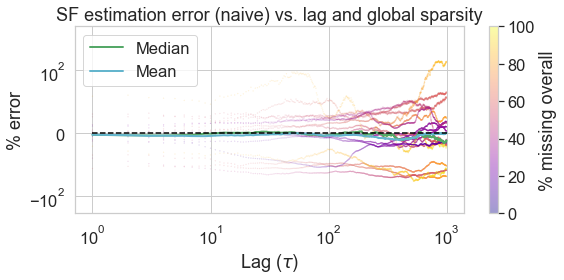

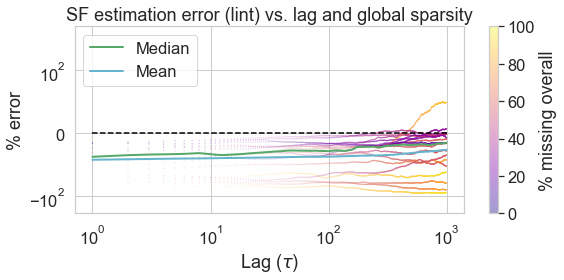

In [19]:
for gap_handling in sfs_gapped.gap_handling.unique():
    sf.plot_error_trend_line(sfs_gapped[sfs_gapped["gap_handling"]==gap_handling], estimator="sf_2", title = f"SF estimation error ({gap_handling}) vs. lag and global sparsity", y_axis_log=True)
    plt.savefig(f"plots/temp/train_{spacecraft}_error_trend_{gap_handling}.jpg", bbox_inches='tight')